3부 예측에서 포트폴리오로

10장 검증 및 튜닝

ROC 곡선 계산

In [2]:
from data_processing import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# 데이터 준비 및 저장
prepare_and_store_data("data_ml.csv")

# 데이터 가져오기
data_ml = get_data_ml()
training_sample = get_training_sample()
testing_sample = get_testing_sample()
features = get_features()
features_short = get_features_short()

# 결과 확인
print("Data ML Shape:", data_ml.shape)
print("Training Sample Shape:", training_sample.shape)
print("Testing Sample Shape:", testing_sample.shape)
print("Features:", features_short)


Data ML Shape: (536672, 103)
Training Sample Shape: (396256, 103)
Testing Sample Shape: (140416, 103)
Features: ['Div_Yld', 'Eps', 'Mkt_Cap_12M_Usd', 'Mom_11M_Usd', 'Ocf', 'Pb', 'Vol1Y_Usd']


In [3]:
from sklearn.ensemble import RandomForestClassifier
fit_RF_C = RandomForestClassifier(
    n_estimators=40,
    criterion='gini',
    min_samples_split=250,
    bootstrap=True,
    max_features=30,
    max_samples=20000
)

y_train = training_sample['R1M_Usd'].values
X_train = training_sample[features].values

y_test = testing_sample['R1M_Usd'].values
X_test = testing_sample[features].values

y_c_train = training_sample['R1M_Usd_C'].values
y_c_test = testing_sample['R1M_Usd_C'].values

fit_RF_C = fit_RF_C.fit(X_train, y_c_train)
hitratio = np.mean(fit_RF_C.predict(X_test) == y_c_test)
print(f'Hit Ratio: {hitratio}')

Hit Ratio: 0.5009258204193254


c:\ProgramData\miniconda3\envs\tensor\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


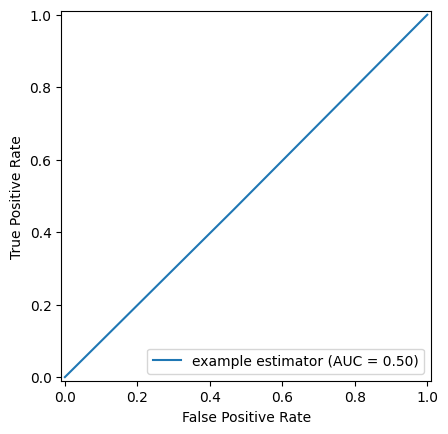

AUC :0.4982213799430143


In [6]:
from sklearn.metrics import roc_curve, RocCurveDisplay, auc
import matplotlib.pyplot as plt

# AUC 계산을 위한 모듈
fpr, tpr, thresholds = roc_curve(testing_sample['R1M_Usd_C'].values, fit_RF_C.predict(testing_sample[features]))
roc_auc = auc(fpr,tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                          estimator_name='example estimator')
display.plot()
plt.show()
print(f'AUC :{roc_auc}')

분산-편향 트레이드 오프 : 릿지 회귀

In [12]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet
y_penalized = data_ml['R1M_Usd'].values
X_penalized = data_ml[features].values
alphas = np.arange(1e-4, 1.0e-3, 1e-5)
lasso_res = {}

for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_penalized, y_penalized)
    lasso_res[alpha] = lasso.coef_

df_lasso_res = pd.DataFrame.from_dict(lasso_res).T
df_lasso_res.columns = features
predictors = (df_lasso_res.abs().sum() > 0.05) # 신뢰도 높은 예측 인자 선택

n_alphas = 50
alphas = np.logspace(-2, 4, n_alphas)
ridge_res = {}
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_penalized, y_penalized)
    ridge_res[alpha] = ridge.coef_
df_ridge_res = pd.DataFrame.from_dict(ridge_res).T
df_ridge_res.columns = features

array([<Axes: xlabel='Lambda'>, <Axes: xlabel='Lambda'>,
       <Axes: xlabel='Lambda'>], dtype=object)

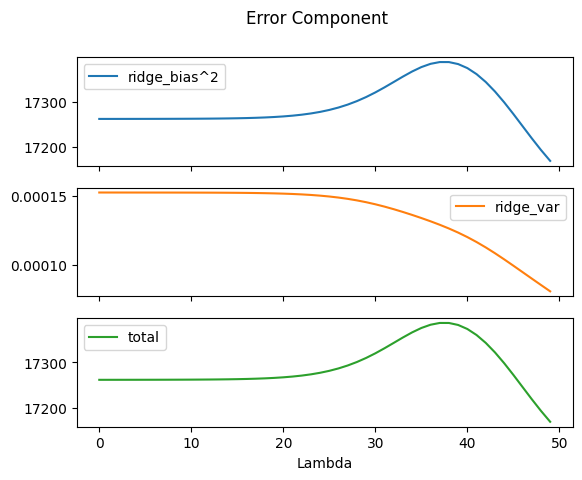

In [15]:
ridge_bias = []
ridge_var = []
for alpha in range(0, len(alphas),1):
    predictions = np.dot((df_ridge_res.iloc[alpha,:].values),X_penalized.T)
    ridge_bias.append(np.sum(np.square(predictions - y_penalized)))
    ridge_var.append(np.var(predictions))
df = pd.DataFrame(list(zip(ridge_bias, ridge_var)),
                  columns = ['ridge_bias^2', 'ridge_var'])
df['total'] = df['ridge_bias^2'] + df['ridge_var']
df.plot(subplots=True, title='Error Component', xlabel='Lambda')

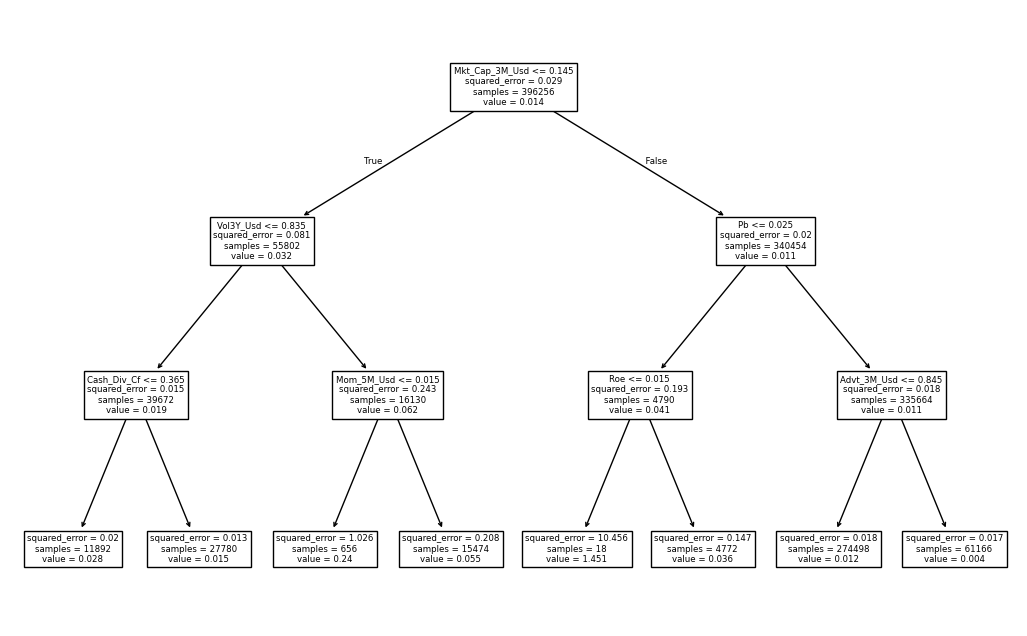

In [16]:
from sklearn import tree

X = training_sample[features]
y = y_train
fit_tree_simple = tree.DecisionTreeRegressor(
    max_depth=3,
    ccp_alpha=0.000001
)
fit_tree_simple.fit(X,y)
fig, ax = plt.subplots(figsize=(13, 8))
tree.plot_tree(fit_tree_simple, feature_names=X.columns.values, ax=ax)
plt.show()

In [17]:
bias_tree = np.mean(fit_tree_simple.predict(X_test) - y_test)
var_tree = np.var(fit_tree_simple.predict(X_test))
print(f'bias: {bias_tree}')
print(f'var: {var_tree}')

bias: 0.005403416308537764
var: 0.0005820795866579898


c:\ProgramData\miniconda3\envs\tensor\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
c:\ProgramData\miniconda3\envs\tensor\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


10.3 좋은 하이퍼파라미터 찾기

10.3.2 격자탐색

In [1]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error
scorer = make_scorer(mean_absolute_error)
params = {
    'learning_rate' : [0.1, 0.3, 0.5, 0.7, 0.9],
    'n_estimators' : [10, 50, 100],
    'reg_lambda' : [0.01, 0.1, 1, 10, 100]
}
print(params)

{'learning_rate': [0.1, 0.3, 0.5, 0.7, 0.9], 'n_estimators': [10, 50, 100], 'reg_lambda': [0.01, 0.1, 1, 10, 100]}


In [4]:
import xgboost as xgb


model = xgb.XGBRegressor(max_depth =3, n_jobs=-1,
                         objedtive='reg:squarederror')
model_gs = GridSearchCV(
    model, param_grid=params, cv=2, scoring='neg_mean_squared_error'
)
model_gs.fit(X_train, y_train)
cv_results = pd.DataFrame(model_gs.cv_results_)
print(f'Best Parameters using grid search: {model_gs.best_params_}')

c:\ProgramData\miniconda3\envs\tensor\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:24:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "objedtive" } are not used.

  warnings.warn(smsg, UserWarning)
c:\ProgramData\miniconda3\envs\tensor\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:24:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "objedtive" } are not used.

  warnings.warn(smsg, UserWarning)
c:\ProgramData\miniconda3\envs\tensor\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:24:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "objedtive" } are not used.

  warnings.warn(smsg, UserWarning)
c:\ProgramData\miniconda3\en

Best Parameters using grid search: {'learning_rate': 0.7, 'n_estimators': 100, 'reg_lambda': 0.1}


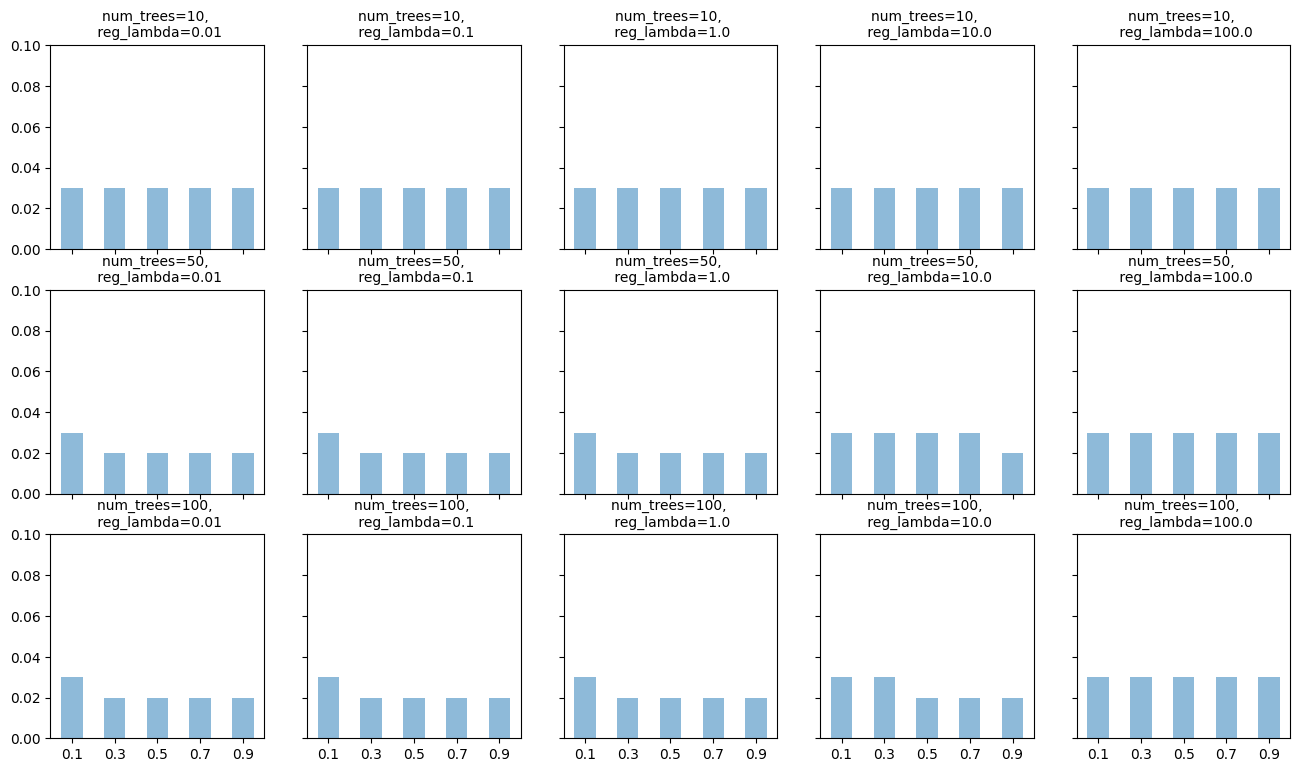

In [7]:
res_df = pd.DataFrame(cv_results,
                      columns=["param_n_estimators", "param_learning_rate",
                               "param_reg_lambda", "mean_test_score"])
#MAE 가 최대가 되도록 사이킷런에서는 음수로 설정함.
#따라서 부호 무시하고 모든 오차가 양수라고 가정가능.
res_df['mean_test_score'] = -res_df['mean_test_score'].values
fig, axes = plt.subplots(figsize=(16,9), nrows=3, ncols=5)
ax_all = plt.gca()
cnt = 0
for param, tmp in res_df.groupby(["param_n_estimators", "param_reg_lambda"]):
    ax = axes[cnt//5][cnt%5]
    np.round(
        tmp[["param_learning_rate", "mean_test_score"]],2).plot.bar(
            ax=ax, x="param_learning_rate", y="mean_test_score", alpha=0.5, legend=None
        )
    ax.set_xlabel("")
    ax.set_ylim(0, 0.1)
    if cnt//5 < 2:
        ax.xaxis.set_ticklabels("")
    else:
        for label in ax.get_xticklabels():
            label.set_rotation(0);
    if cnt%5 > 0:
        ax.yaxis.set_ticklabels("")
    
    ax.set_title(
        f"num_trees={param[0]}, \n reg_lambda={param[1]}", fontsize=10);
    
    cnt = cnt+1

10.3.3 베이지안 최적화

In [8]:
from skopt import BayesSearchCV
search_spaces = params
opt = BayesSearchCV(estimator=model,
                    search_spaces=search_spaces,
                    scoring='neg_mean_squared_error',
                    cv=2)
opt.fit(X_train, y_train)
cv_results_opt = pd.DataFrame(opt.cv_results_)

c:\ProgramData\miniconda3\envs\tensor\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:46:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "objedtive" } are not used.

  warnings.warn(smsg, UserWarning)
c:\ProgramData\miniconda3\envs\tensor\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:46:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "objedtive" } are not used.

  warnings.warn(smsg, UserWarning)
c:\ProgramData\miniconda3\envs\tensor\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:46:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "objedtive" } are not used.

  warnings.warn(smsg, UserWarning)
c:\ProgramData\miniconda3\en

In [10]:
print(f'Best Parameters using bayes opt: {opt.best_params_}')

Best Parameters using bayes opt: OrderedDict({'learning_rate': 0.7, 'n_estimators': 100, 'reg_lambda': 0.1})


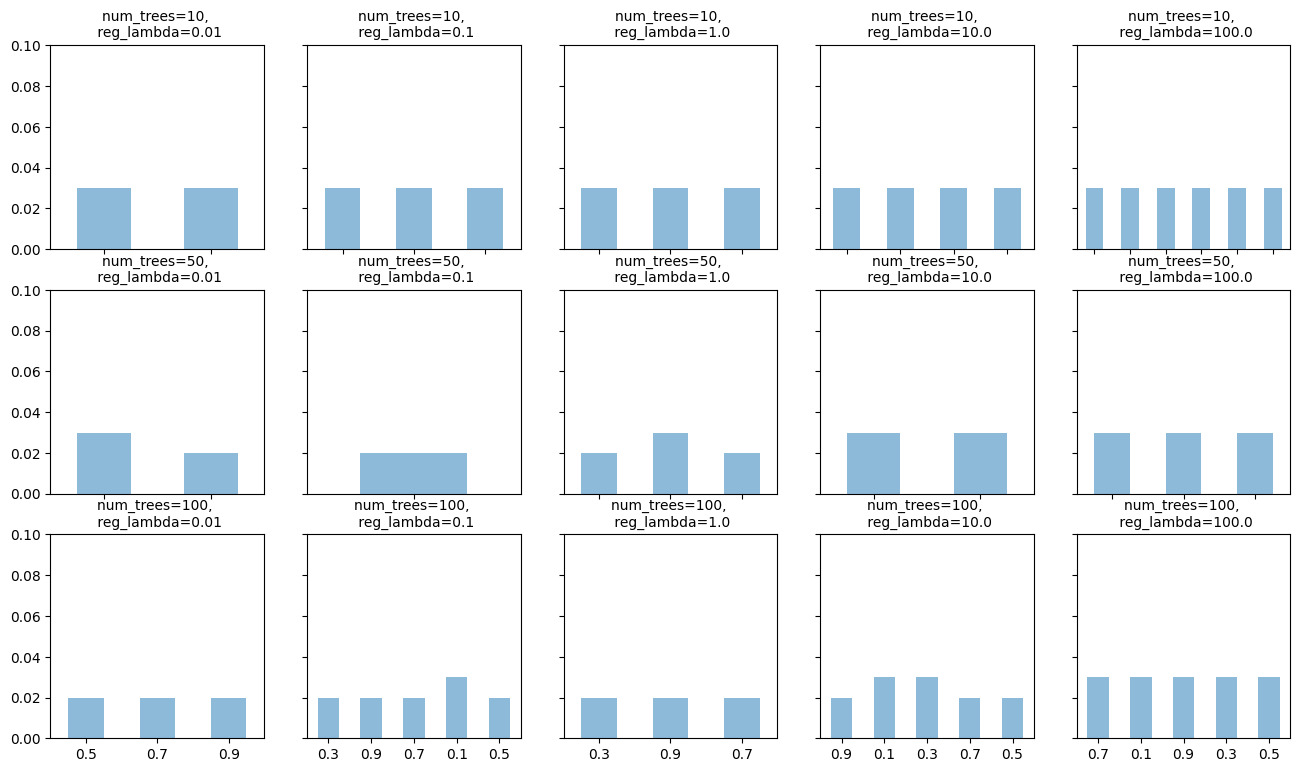

In [12]:
res_df = pd.DataFrame(cv_results_opt,
                      columns=["param_n_estimators", "param_learning_rate",
                               "param_reg_lambda", "mean_test_score"])
res_df['mean_test_score'] = -res_df['mean_test_score'].values
fig, axes = plt.subplots(figsize=(16,9), nrows=3, ncols=5)
ax_all = plt.gca()
cnt = 0
for param, tmp in res_df.groupby(["param_n_estimators", "param_reg_lambda"]):
    ax = axes[cnt//5][cnt%5]
    np.round(tmp[["param_learning_rate", "mean_test_score"]], 2).plot.bar(
        ax=ax, x="param_learning_rate", y="mean_test_score",alpha=0.5,legend=None
    )
    ax.set_xlabel("")
    ax.set_ylim(0, 0.1)
    if cnt//5 < 2:
        ax.xaxis.set_ticklabels("")
    else:
        for label in ax.get_xticklabels():
            label.set_rotation(0);
    if cnt%5 > 0:
        ax.yaxis.set_ticklabels("")
    
    ax.set_title(f"num_trees={param[0]}, \n reg_lambda={param[1]}", fontsize=10);
    
    cnt = cnt + 1